# Subreddit Text Analysis

In [1]:
import praw
import pickle
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Using TensorFlow backend.
c:\users\nfberthusen\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Enter Subreddit to Analyze

In [2]:
subreddit = "The_Donald"
num_posts = 20
sort = "year" #{'top', 'year', 'all'}

In [3]:
common_words = set(["http","https","com","org","www","imgur","r","removed","deleted","nbsp","did","had","don't","us","been","a","about","all","are","an","also","and","as","at","be","because","but","by","can","come","could","day","do","deleted","even","find","first","for","from","get","give","go","have","he","her","here","him","has","his","how","i","is","if","in","into","it","its","it's","i'm","just","know","like","look","make","man","many","me","more","my","new","no","not","now","of","on","one","only","or","other","our","out","people","say","see","she","so","some","take","tell","than","that","the","their","them","then","there","these","they","thing","think","this","those","time","to","two","up","use","very","want","was","way","we","were","well","what","when","which","who","will","with","would","year","you","your"])
texts = []
word_count = 0
reddit = praw.Reddit(client_id='Wa_QQy6c8J6w_Q',
                     client_secret='i7XCwT6iYlE4O1wLqjJCfDRsFV0',
                     user_agent='diggity_diggity_doge')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
model = load_model('70betterliberal.h5')

In [4]:
def get_comments_top_year(subreddit, number):
    for submission in reddit.subreddit(subreddit).top('year', limit=number):
        submission.comment_sort = 'top'
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            texts.append(parse_comment(comment.body))

def get_comments_top_all(subreddit, number):
    for submission in reddit.subreddit(subreddit).top(limit=number):
        submission.comment_sort = 'top'
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            texts.append(parse_comment(comment.body))

def get_comments_hot(subreddit, number):
    for submission in reddit.subreddit(subreddit).hot(limit=number):
        submission.comment_sort = 'top'
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            texts.append(parse_comment(comment.body))

def parse_comment(comment):
    global word_count
    comment_arr = []
    new_comment = comment.translate ({ord(c): " " for c in "!@#$%^&*()[]{};:,./<>?\|`~-=_+"})
    for word in new_comment.split():
        word_count = word_count + 1
        if word.lower() not in common_words:
            comment_arr.append(word.lower())
    return " ".join(comment_arr)


def tokenize_words(texts):
    max_words = 10000
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    return tokenizer    

def plot_occurence_data(tokenizer, subreddit):
    sorted_by_value = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1])

    data = pd.DataFrame(sorted_by_value, columns=['word', 'occurence']).tail(25)
    data['occurence'] = data['occurence']/word_count
    data.set_index("word",drop=True,inplace=True)
    
    ax = data.plot(kind='bar', figsize=(10,10))
    ax.set_title('Most common words in r/%s' %subreddit)
    ax.set_ylabel('Percent occurence out of %d words' %word_count)
    ax.set_xlabel('Word')

def convert_to_token(comment, tokenizer):
    comment_arr = [comment]
    comment_token = tokenizer.texts_to_sequences(comment_arr)
    return comment_token

def build_corpus(data):
    corpus = []
    for sentence in data:
        word_list = sentence.split(" ")
        corpus.append(word_list)
    return corpus

def tsne_plot(model):
    "Creates a TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 15)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [5]:
if(sort == 'year'):
    get_comments_top_year(subreddit, num_posts)
elif(sort == 'hot'):
    get_comments_hot(subreddit, num_posts)
elif(sort == 'all'):
    get_comments_top_all(subreddit, num_posts)
else:
    print('Not an appropriate sort method.')

In [6]:
token = tokenize_words(texts)
corpus = build_corpus(texts)

In [7]:
test_tokens = token.texts_to_sequences(texts)
test_tokens = pad_sequences(test_tokens, maxlen=100)

In [8]:
predictions = model.predict_classes(test_tokens, batch_size=10)
unique, counts = np.unique(predictions, return_counts=True)
classes = dict(zip(unique, counts))

In [9]:
classes

{0: 14067, 1: 8507}

In [20]:
word_model = word2vec.Word2Vec(corpus, size=100, window=5, min_count=250)

In [21]:
len(word_model.wv.vocab)

132

### Political Alignment Bar Chart

Text(0.5,0,'Stance')

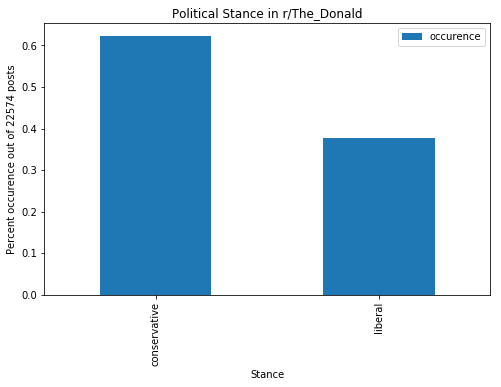

In [22]:
arr = [['conservative', classes[0]],['liberal', classes[1]]]
df = pd.DataFrame(arr, columns=['alignment', 'occurence'])
df['occurence'] = df['occurence']/len(texts)
ax = df.plot(kind='bar', x='alignment', figsize=(8,5))
ax.set_title('Political Stance in r/%s' %subreddit)
ax.set_ylabel('Percent occurence out of %d posts' %len(texts))
ax.set_xlabel('Stance')

### Word Network

c:\users\nfberthusen\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:69: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


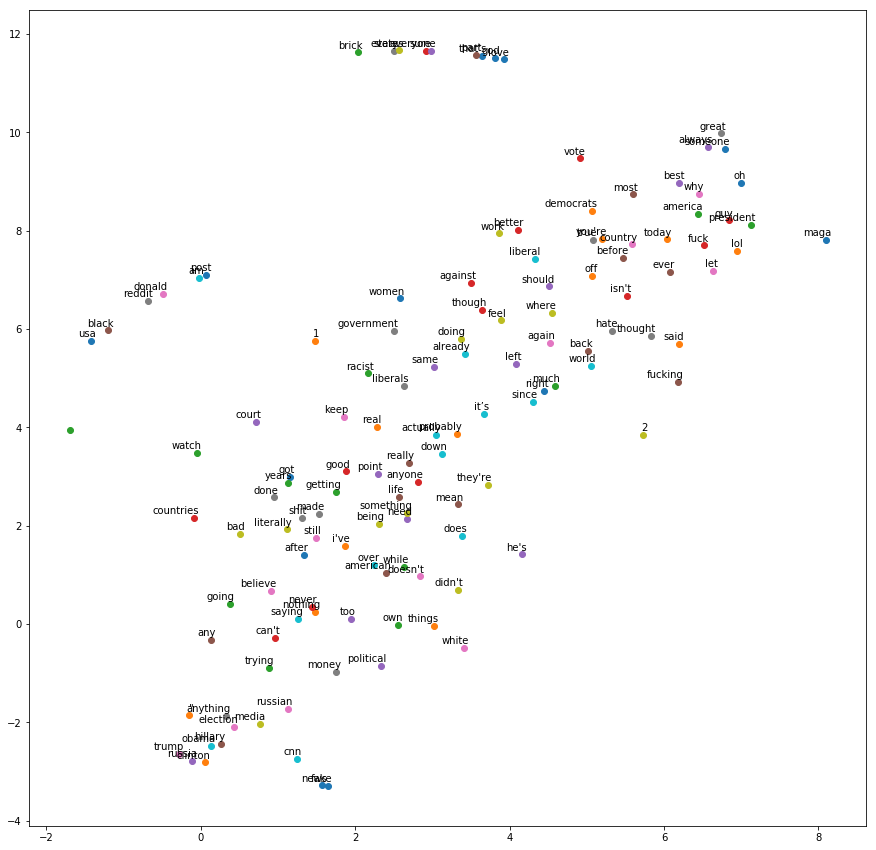

In [23]:
tsne_plot(word_model)

### Word Occurence

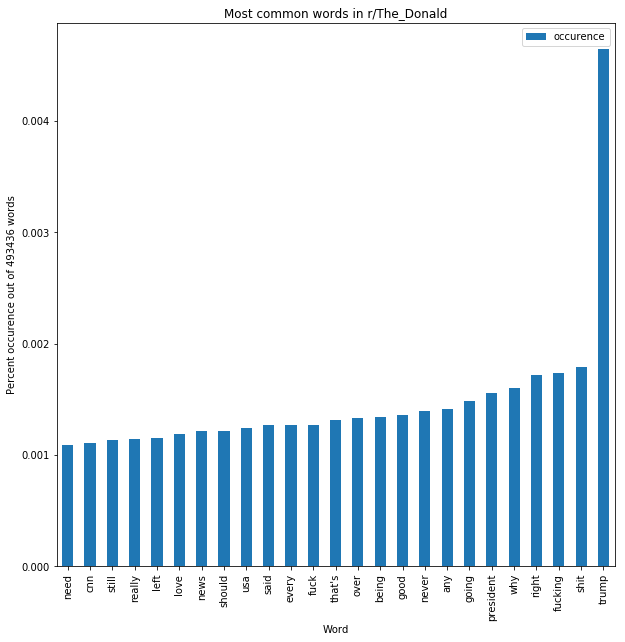

In [24]:
plot_occurence_data(token, subreddit)